In [1]:
# Copy of fake_detection.ipynb but with sid_extragal_short_gr_100_rchi2min3.dat data set
# Find most realistic simulations to real ztf_dr4 data

In [2]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from coniferest.isoforest import IsolationForest
from coniferest.pineforest import PineForest

from pathlib import Path

%config InlineBackend.figure_format = 'retina'

In [3]:
# First of all: load data

from zwad.utils import load_data

def feature_file(oid_file):
    parent = oid_file.parent
    if oid_file.name.startswith('oid_'):
        name = oid_file.name.replace('oid_', 'feature_')
    else:
        name = oid_file.name.replace('sid_', 'feature_')
    
    return parent.joinpath(name)
    

datadir = Path('../features_data', 'dr4_new')
sid_extragal_gr = datadir.joinpath('sid_extragal_short_gr_100_rchi2min3.dat')
feature_extragal_gr = feature_file(sid_extragal_gr)

fakesdir = Path('../sim_fake', 'output')
sid_fakes = list(fakesdir.glob('oid_*.dat'))
feature_fakes = [feature_file(s) for s in sid_fakes]

sids, features = load_data([sid_extragal_gr] + sid_fakes, [feature_extragal_gr] + feature_fakes)

In [4]:
sid_fakes

[PosixPath('../sim_fake/output/oid_sim_62_SNIbc.dat'),
 PosixPath('../sim_fake/output/oid_sim_42_SNII-NMF.dat'),
 PosixPath('../sim_fake/output/oid_sim_64_TDE.dat'),
 PosixPath('../sim_fake/output/oid_sim_90_SNIa.dat'),
 PosixPath('../sim_fake/output/oid_sim_60_SLSN-I.dat')]

In [5]:
%%time

# Perform calculations of outliers

isoforest = IsolationForest(n_subsamples=1024, n_trees=1000) # n_subsamples=1024, n_trees=1000
isoforest.fit(features)
scores = isoforest.score_samples(features)
ordered_sids = sids[np.argsort(scores)]
detection_curve = np.cumsum(ordered_sids < 1e10)

CPU times: user 1min 36s, sys: 739 ms, total: 1min 36s
Wall time: 1min 38s


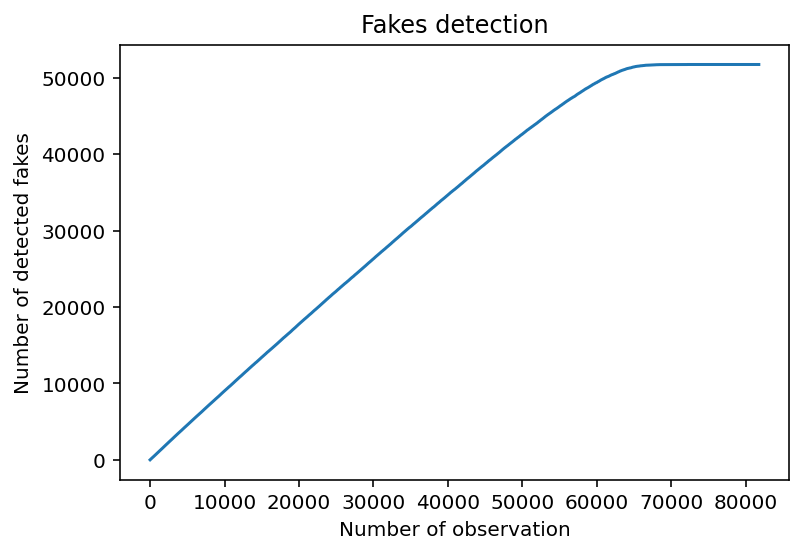

In [6]:
# Plot the detection curve

n_fakes = detection_curve[-1]

plt.plot(detection_curve[:n_fakes+30000]) # 10000 is for extragal_short_gr_100.tar
plt.xlabel('Number of observation')
plt.ylabel('Number of detected fakes')
plt.title('Fakes detection')
pass

In [7]:
n_fakes - detection_curve[60000]

2379

In [8]:
n_fakes - detection_curve[1000000]

0

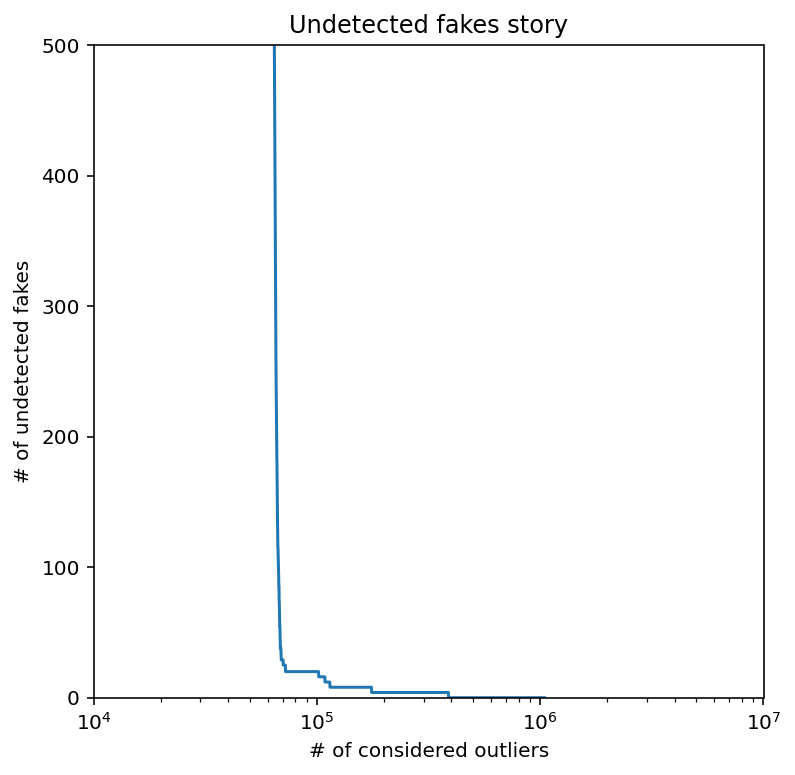

In [9]:
plt.figure(figsize=(6, 6))
plt.title('Undetected fakes story')
plt.plot(np.arange(0, len(detection_curve), 100), n_fakes - detection_curve[::100])
plt.xlabel('# of considered outliers')
plt.xlim(1e4, 1e7)
plt.xscale('log')
plt.ylabel('# of undetected fakes')
plt.ylim(0, 500)
pass

In [10]:
%%time

isoforest = IsolationForest(n_subsamples=1024, n_trees=10000)
isoforest.fit(features)
fake_trees = PineForest.filter_trees(isoforest.trees, features[-n_fakes:], np.full(n_fakes, -1), 9000)

CPU times: user 2min 31s, sys: 10.5 s, total: 2min 42s
Wall time: 2min 45s


In [11]:
def get_most_frequent_roots(trees, n_hits=10):
    bins = np.bincount([tree.__getstate__()['nodes'][0]['feature'] for tree in trees])
    sort_index = np.argsort(bins)[::-1]
    sorted_bins = bins[sort_index]
    index = np.argwhere(sorted_bins >= n_hits).ravel()
    return sort_index[index]

In [12]:
roots = get_most_frequent_roots(fake_trees, n_hits=25) #30 in original returns none
roots

array([77, 59, 17, 19, 41,  6, 75])

In [13]:
feature_names = Path('../features_data', 'dr4_new', 'feature_extragal_short_gr_100_rchi2min3.name').open('r').read().split('\n')


def plot_feature_histogram(feature):
    values = features[:, feature]
    bins = np.linspace(values.min(), values.max(), 30)

    plt.figure()
    plt.title(f'Feature #{feature}({feature_names[feature]}) histogram')
    plt.hist(values[:-n_fakes], bins=bins, alpha=0.5, label='dr4')
    plt.hist(values[-n_fakes:], bins=bins, alpha=0.5, label='fakes')
    plt.yscale('log')
    plt.legend()
    
    dr4_value = values[:-n_fakes]
    fakes_value = values[-n_fakes:]
    
    return dr4_value, fakes_value, feature_names[feature]

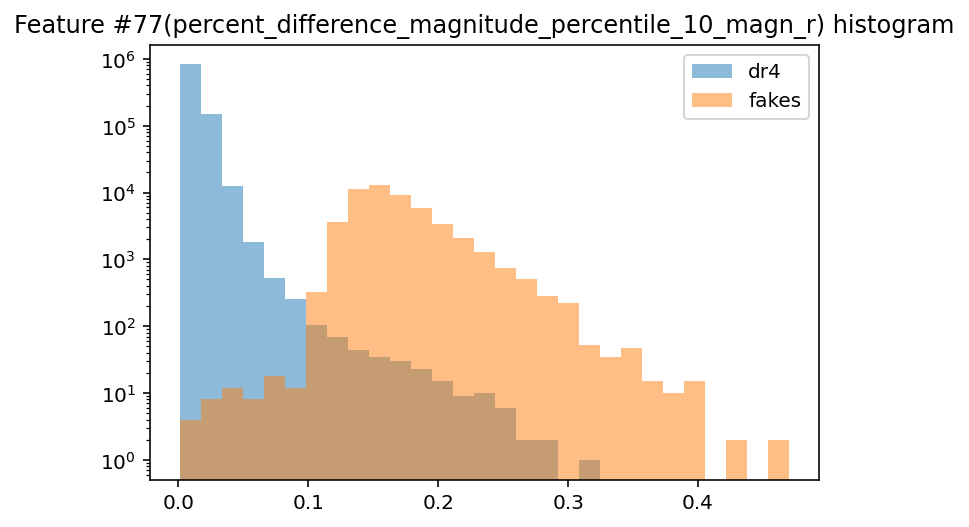

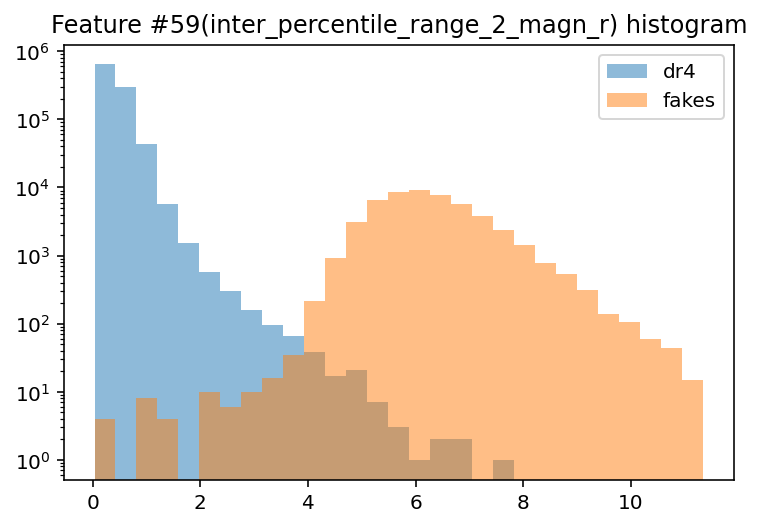

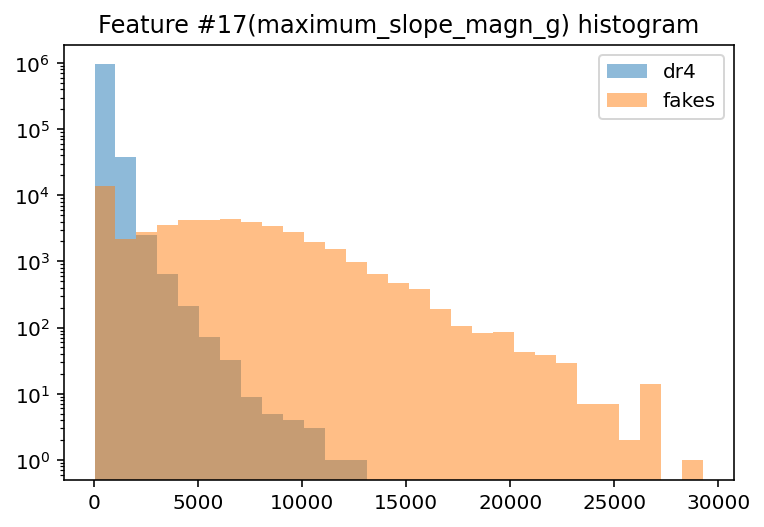

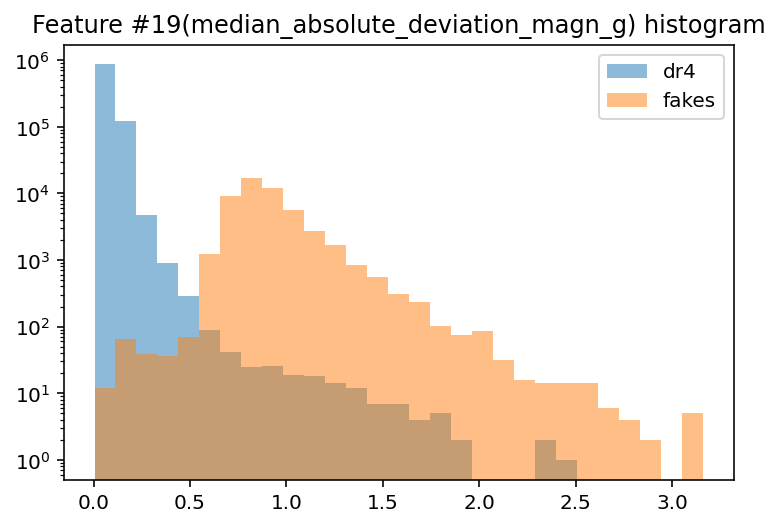

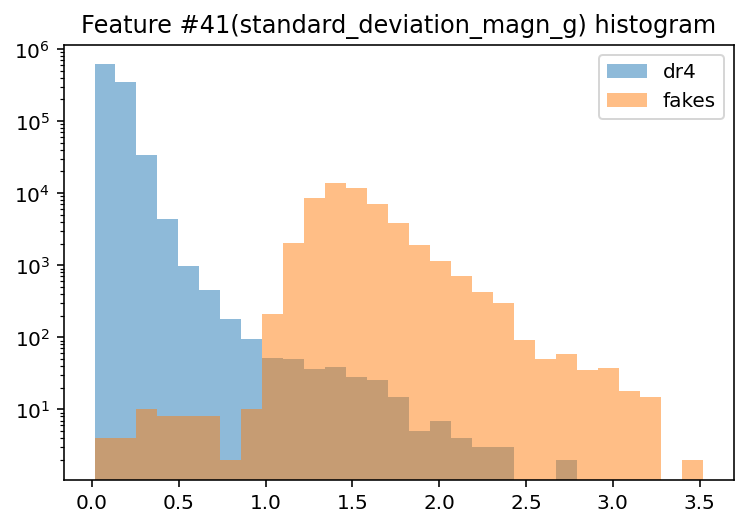

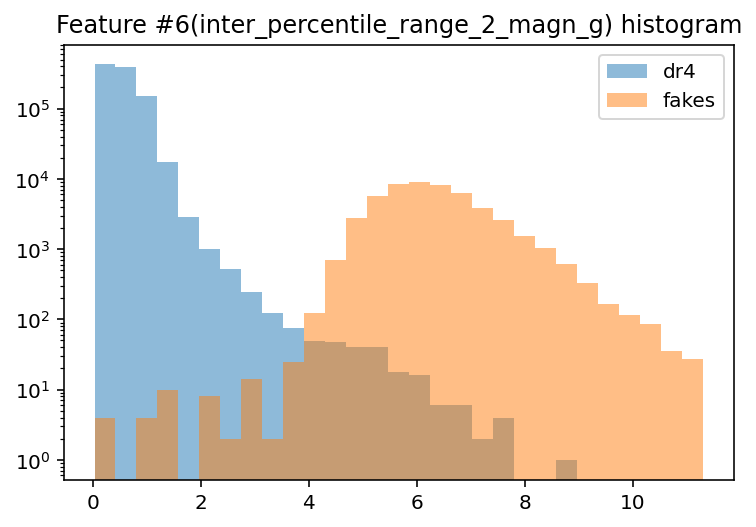

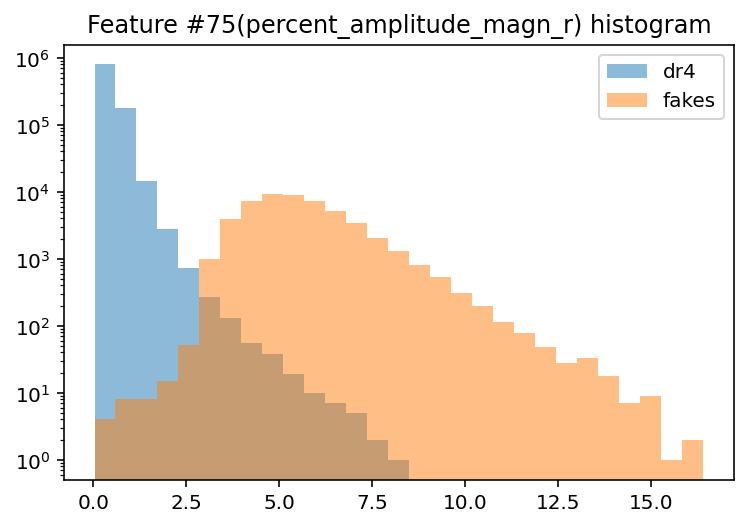

In [14]:
dr4_values_list, fakes_values_list, feature_list = [],[],[]

for root in roots:
    dr4_value, fakes_value, feature = plot_feature_histogram(root)
    plt.show()
    
    dr4_values_list.append(dr4_value)
    fakes_values_list.append(fakes_value)
    feature_list.append(feature)

In [15]:
dr4_values_list

[array([0.0170782 , 0.02028316, 0.0085202 , ..., 0.00555182, 0.01238895,
        0.01474143], dtype=float32),
 array([0.32127953, 0.42856026, 0.35136032, ..., 0.14972019, 0.3278389 ,
        0.34291935], dtype=float32),
 array([192.2375 , 524.2917 , 211.9    , ..., 157.2875 , 493.70416,
        480.59583], dtype=float32),
 array([0.06850052, 0.05049896, 0.04799843, ..., 0.01699924, 0.03800201,
        0.04949999], dtype=float32),
 array([0.10506912, 0.12311856, 0.1169537 , ..., 0.02427343, 0.06077003,
        0.07009372], dtype=float32),
 array([0.34149933, 0.5230007 , 0.55999947, ..., 0.09364033, 0.23400116,
        0.24200058], dtype=float32),
 array([0.23500061, 0.23999977, 0.3260002 , ..., 0.11900043, 0.33499908,
        0.24900055], dtype=float32)]

In [16]:
fakes_values_list

[array([0.15541475, 0.142971  , 0.10593148, ..., 0.19276436, 0.13184838,
        0.13566624], dtype=float32),
 array([5.9201975, 5.698882 , 4.4808774, ..., 7.434895 , 5.36441  ,
        6.3332443], dtype=float32),
 array([3626.358  ,  210.30647, 7434.393  , ...,  256.4379 , 4678.2017 ,
        2514.5337 ], dtype=float32),
 array([0.8039284 , 0.6269026 , 0.81715584, ..., 0.89305305, 0.7110481 ,
        0.7557545 ], dtype=float32),
 array([1.3541842, 1.4603255, 1.3877823, ..., 1.6728503, 1.3612489,
        1.144408 ], dtype=float32),
 array([6.6488576, 6.145231 , 6.1872835, ..., 7.4602685, 6.708557 ,
        4.811396 ], dtype=float32),
 array([5.3402653, 4.187826 , 4.215    , ..., 5.441099 , 4.910591 ,
        4.579749 ], dtype=float32)]

In [17]:
feature_list

['percent_difference_magnitude_percentile_10_magn_r',
 'inter_percentile_range_2_magn_r',
 'maximum_slope_magn_g',
 'median_absolute_deviation_magn_g',
 'standard_deviation_magn_g',
 'inter_percentile_range_2_magn_g',
 'percent_amplitude_magn_r']

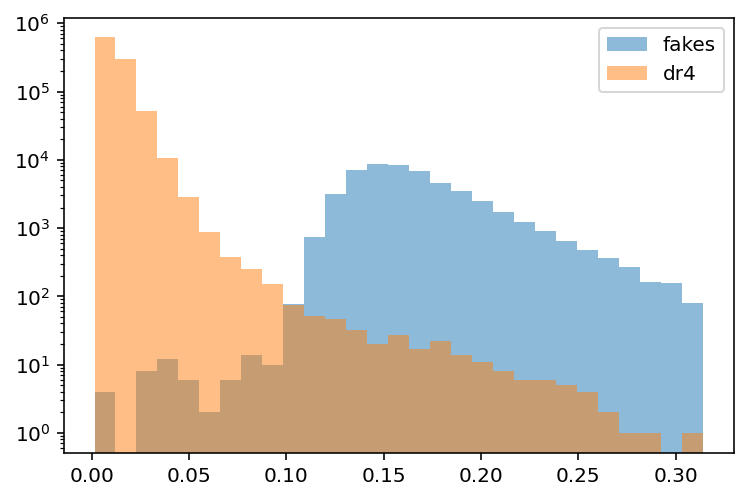

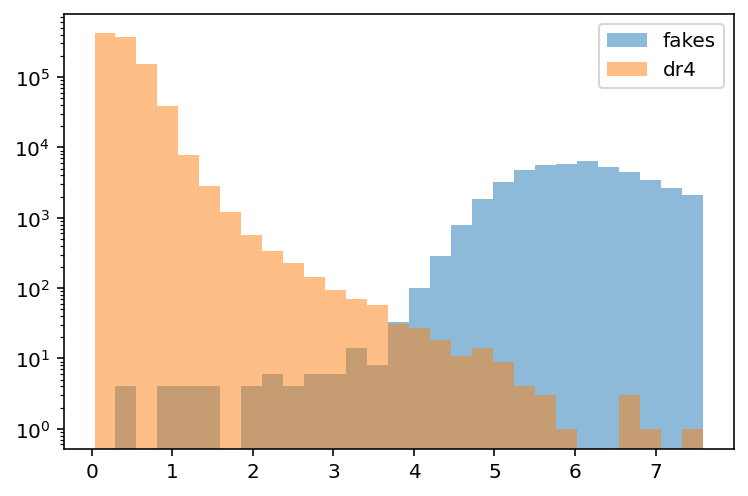

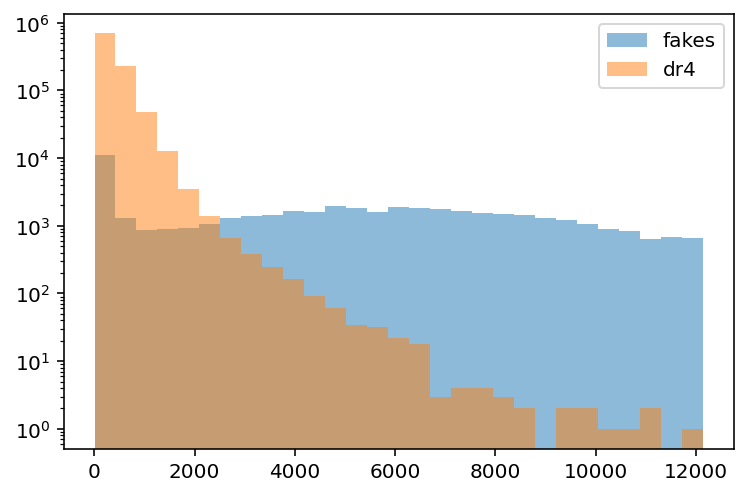

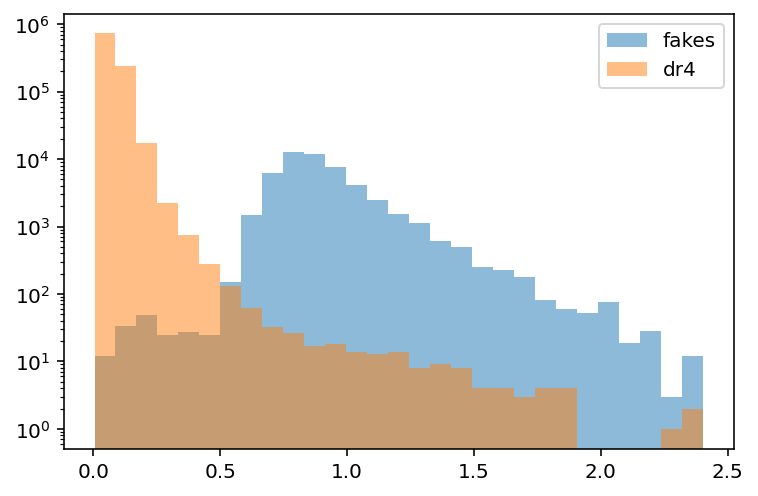

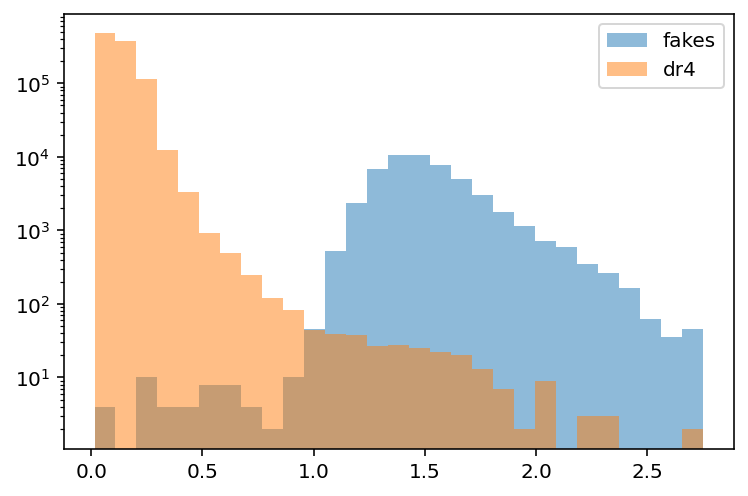

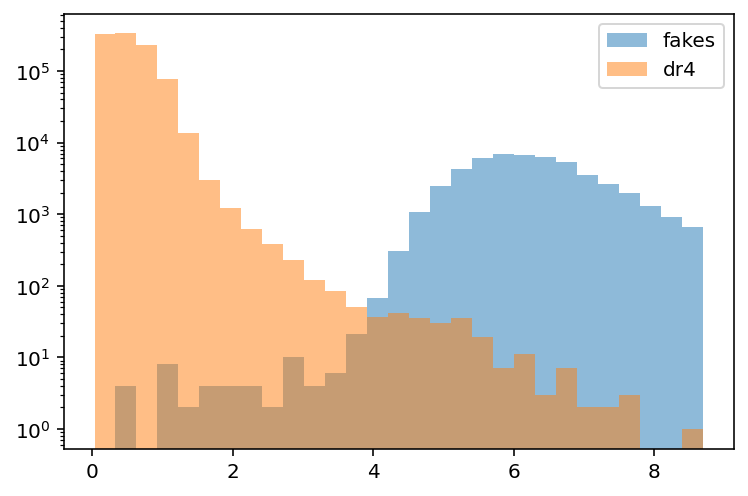

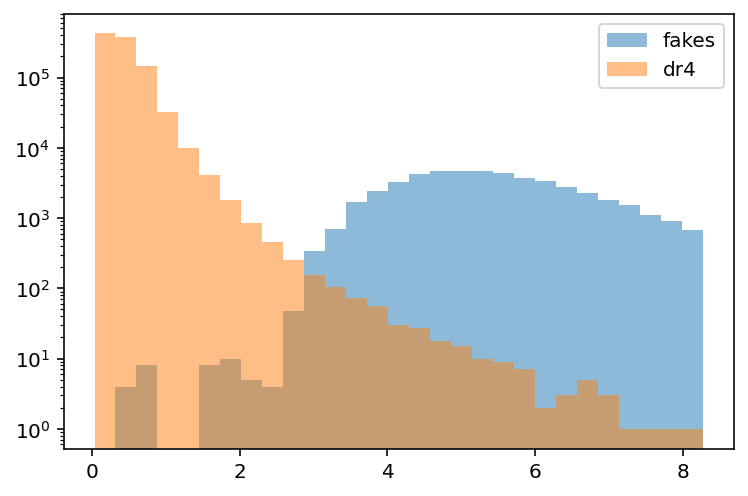

In [19]:
# Find and return only objects where dr4 and fakes overlap for features (so sims reflect reality)

for dr4_vs, fakes_vs, feat in zip(dr4_values_list, fakes_values_list, feature_list):
    
    min_dr4, max_dr4 = min(dr4_vs), max(dr4_vs) 
    fakes_vs = fakes_vs[(fakes_vs > min_dr4) & (fakes_vs < max_dr4)]
    
    bins = np.linspace(min_dr4, max_dr4, 30)
    plt.hist(fakes_vs, bins=bins, alpha=0.5, label='fakes')
    plt.hist(dr4_vs, bins=bins, alpha=0.5, label='dr4')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [20]:
dr4_index = [sids > 1e10]
dr4_sids = sids[dr4_index]
dr4_features = features[dr4_index]

fakes_index = [sids < 1e10]
fakes_sids = sids[fakes_index]
fakes_features = features[fakes_index]

<ipython-input-20-1290c42e22d8>:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dr4_sids = sids[dr4_index]
<ipython-input-20-1290c42e22d8>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dr4_features = features[dr4_index]
<ipython-input-20-1290c42e22d8>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  fakes_sids 

In [21]:
roots_dr4_features = dr4_features[:, roots]
roots_fakes_features = fakes_features[:, roots]

In [22]:
%%time

from sklearn.neighbors import KDTree

X = roots_fakes_features
kdtree = KDTree(roots_dr4_features)              
dist, ind = kdtree.query(X, k=2)

print(dist[:, 1])    # drop id; assumes sorted -> see args!
print(ind[:, 1])     # drop id

[  9.17274415   4.38559252 115.76742813 ...   5.65328327   8.35486382
   7.17399852]
[623973  51765 360331 ... 535013 405931 321513]
CPU times: user 2.3 s, sys: 25.6 ms, total: 2.32 s
Wall time: 2.32 s


(array([4.9536e+04, 1.1000e+03, 6.2500e+02, 2.3700e+02, 1.3000e+02,
        8.1000e+01, 2.9000e+01, 1.6000e+01, 1.4000e+01, 1.0000e+00]),
 array([2.71970405e-01, 1.80779671e+03, 3.61532145e+03, 5.42284618e+03,
        7.23037092e+03, 9.03789566e+03, 1.08454204e+04, 1.26529451e+04,
        1.44604699e+04, 1.62679946e+04, 1.80755193e+04]),
 <BarContainer object of 10 artists>)

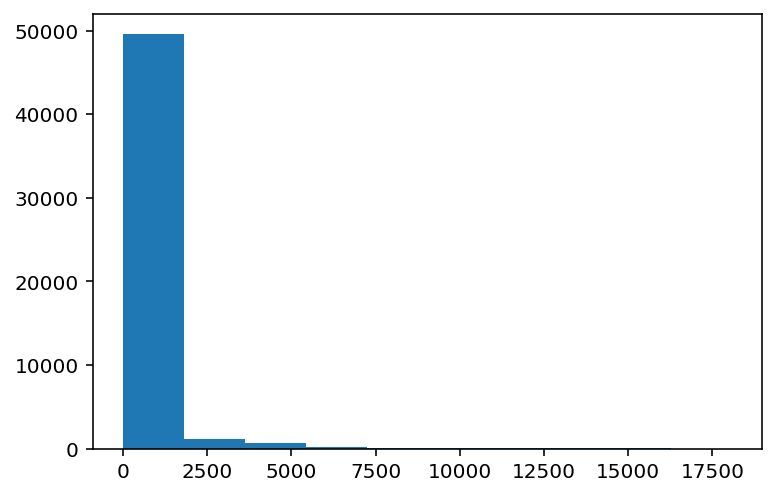

In [23]:
plt.hist(dist[:, 1])

(array([ 4277.,  4317.,  3710., 11697.,  4051., 13653.,  3659.,  2490.,
         2986.,   929.]),
 array([4.000000e+00, 9.867120e+04, 1.973384e+05, 2.960056e+05,
        3.946728e+05, 4.933400e+05, 5.920072e+05, 6.906744e+05,
        7.893416e+05, 8.880088e+05, 9.866760e+05]),
 <BarContainer object of 10 artists>)

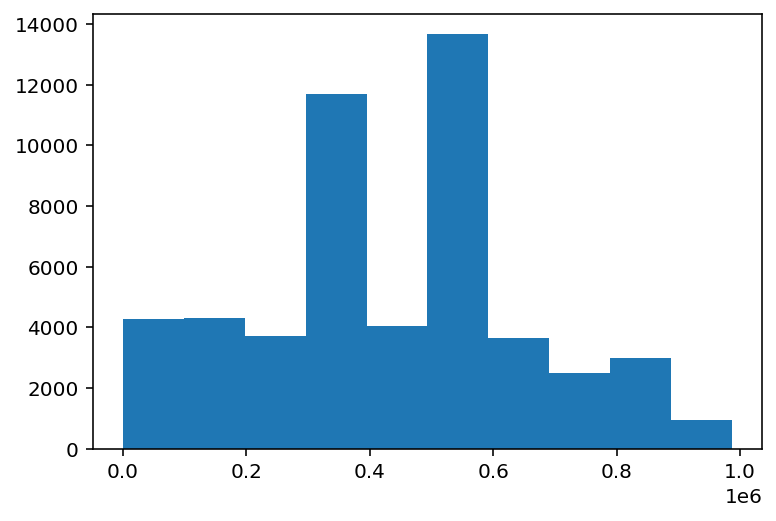

In [24]:
plt.hist(ind[:, 1])

In [41]:
# Number closest objects within distance (set threshold)
# Of fakes, what are fakes index w/ closest distance to real data?
threshold = 1.5
closest_dist_index = np.argwhere(dist[:, 1] <= threshold).ravel()
print('Total # of convincing fakes (no duplicate):', len(closest_dist_index))
print(closest_dist_index)

Total # of convincing fakes (no duplicate): 33
[ 1585  1709  1738  2605  5396  5592  6407  7046 13705 13829 13858 20038
 20287 23078 23274 24089 24728 28617 28741 28770 29889 30085 30900 31539
 40544 40668 40697 43962 44211 47002 47198 48013 48652]


In [43]:
fakes_sids_of_closest_dist = fakes_sids[closest_dist_index]
print('Real # of convincing fakes (no duplicates):', len(set(fakes_sids_of_closest_dist)))
fakes_sids_of_closest_dist

Real # of convincing fakes (no duplicates): 9


array([ 647700506,  648956459,  649268336, 6210632910, 6413278367,
       6415552834, 6424807454, 6432340690,  647700506,  648956459,
        649268336, 6036972122, 6210632910, 6413278367, 6415552834,
       6424807454, 6432340690,  647700506,  648956459,  649268336,
       6413278367, 6415552834, 6424807454, 6432340690,  647700506,
        648956459,  649268336, 6036972122, 6210632910, 6413278367,
       6415552834, 6424807454, 6432340690], dtype=uint64)

In [44]:
dr4_sids_of_closest_dist = dr4_sids[closest_dist_index]
dr4_sids_of_closest_dist

array([297105400022875, 297115200022398, 298101100001485, 302101400000861,
       353105100001140, 353116100032553, 363116200000921, 388116100001517,
       408116200001538, 413101400004293, 413105100005867, 452113100001618,
       455109100003424, 477109400000428, 477115200009028, 480115100005224,
       482109400007116, 490113100002553, 490113200001290, 490113200030583,
       491114200026504, 492109400010135, 493113100000658, 496101200002433,
       500115400000395, 500116300014998, 500116400004304, 504112300002963,
       506109100001524, 525105400008029, 525107100006359, 525111100000433,
       525113400000428], dtype=uint64)

In [45]:
pd.DataFrame(zip(fakes_sids_of_closest_dist, dr4_sids_of_closest_dist), columns=[f'fakes_sids_of_dist<{threshold}', 'dr4_sids_of_match'])

,fakes_sids_of_dist<1.5,dr4_sids_of_match
0,647700506,297105400022875
1,648956459,297115200022398
2,649268336,298101100001485
3,6210632910,302101400000861
4,6413278367,353105100001140
5,6415552834,353116100032553
6,6424807454,363116200000921
7,6432340690,388116100001517
8,647700506,408116200001538
9,648956459,413101400004293
